In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/application_train.csv")

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
df.shape

(307511, 122)

In [6]:
df["TARGET"].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [7]:
# creating the decison column for buisness thiking
df["decision"] = df["TARGET"].map({
     0: 'APPROVE',
    1: 'REJECT'
})

In [8]:

df["decision"].value_counts(normalize=True)

decision
APPROVE    0.919271
REJECT     0.080729
Name: proportion, dtype: float64

In [9]:
# as our data is static we are making it dynamic
#1)creating a time column
#2) split data into branches
#3) treat earliers data as baseline
#4) treat later data as monitoring period

# decision_date colum  added

start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2023-12-31")

df['decision_date'] = np.random.choice(
    pd.date_range(start_date, end_date, freq='D'),
    size=len(df)
)


In [10]:
# sort the date for time analysis
df = df.sort_values("decision_date")

In [11]:
df['month'] = df['decision_date'].dt.to_period('M')


In [12]:
df["month"]

270517    2020-01
232130    2020-01
119740    2020-01
99861     2020-01
217954    2020-01
           ...   
187894    2023-12
104606    2023-12
59995     2023-12
244827    2023-12
94403     2023-12
Name: month, Length: 307511, dtype: period[M]

In [13]:
approval_trend = (
    df.groupby("month")["decision"].apply(
        lambda x : (x=="APPROVE").mean()
    )
)
approval_trend.head()

month
2020-01    0.914478
2020-02    0.915812
2020-03    0.917570
2020-04    0.922843
2020-05    0.919477
Freq: M, Name: decision, dtype: float64

# splitting into baseline and monitoring

In [14]:
baseline_months = df["month"].sort_values().unique()[:6]


In [15]:
# spliting the data

baseline_df = df[df["month"].isin(baseline_months)]
monitor_df = df[~df["month"].isin(baseline_months)]

In [16]:
print("Baseline approval rate:",
      (baseline_df['decision'] == 'APPROVE').mean())

print("Monitoring approval rate:",
      (monitor_df['decision'] == 'APPROVE').mean())


Baseline approval rate: 0.9182605980170193
Monitoring approval rate: 0.9194154985060428


# descision drifit detection

In [17]:
baseline_approval_rate = (
    baseline_df["decision"]=="APPROVE"
).mean()

baseline_approval_rate

np.float64(0.9182605980170193)

In [18]:
# monitoring approval rate
monitoring_trend = (
    monitor_df
    .groupby('month')['decision']
    .apply(lambda x: (x == 'APPROVE').mean())
)
print(monitoring_trend)


month
2020-07    0.920809
2020-08    0.918460
2020-09    0.916786
2020-10    0.916590
2020-11    0.918885
2020-12    0.916002
2021-01    0.915793
2021-02    0.915400
2021-03    0.916768
2021-04    0.922363
2021-05    0.922183
2021-06    0.922261
2021-07    0.922042
2021-08    0.919632
2021-09    0.922902
2021-10    0.925545
2021-11    0.922773
2021-12    0.924543
2022-01    0.914557
2022-02    0.914479
2022-03    0.918640
2022-04    0.922278
2022-05    0.915678
2022-06    0.916506
2022-07    0.919846
2022-08    0.920320
2022-09    0.922572
2022-10    0.917352
2022-11    0.914757
2022-12    0.922268
2023-01    0.920115
2023-02    0.912984
2023-03    0.924303
2023-04    0.918211
2023-05    0.911947
2023-06    0.925389
2023-07    0.918336
2023-08    0.924368
2023-09    0.926031
2023-10    0.924191
2023-11    0.910996
2023-12    0.918370
Freq: M, Name: decision, dtype: float64


# comparing baseline vs monitoring (this is DRIFT)

In [19]:
approval_drift = baseline_approval_rate - monitoring_trend
print(approval_drift)

month
2020-07   -0.002548
2020-08   -0.000200
2020-09    0.001474
2020-10    0.001671
2020-11   -0.000624
2020-12    0.002258
2021-01    0.002468
2021-02    0.002860
2021-03    0.001492
2021-04   -0.004103
2021-05   -0.003923
2021-06   -0.004001
2021-07   -0.003781
2021-08   -0.001371
2021-09   -0.004642
2021-10   -0.007284
2021-11   -0.004512
2021-12   -0.006282
2022-01    0.003703
2022-02    0.003781
2022-03   -0.000379
2022-04   -0.004018
2022-05    0.002583
2022-06    0.001754
2022-07   -0.001586
2022-08   -0.002059
2022-09   -0.004311
2022-10    0.000909
2022-11    0.003503
2022-12   -0.004007
2023-01   -0.001855
2023-02    0.005277
2023-03   -0.006042
2023-04    0.000049
2023-05    0.006314
2023-06   -0.007129
2023-07   -0.000075
2023-08   -0.006108
2023-09   -0.007770
2023-10   -0.005930
2023-11    0.007264
2023-12   -0.000110
Freq: M, Name: decision, dtype: float64


In [20]:
DRIFT_THRESHOLD = 0.10


drift_alerts = abs(approval_drift) > DRIFT_THRESHOLD
drift_alerts


month
2020-07    False
2020-08    False
2020-09    False
2020-10    False
2020-11    False
2020-12    False
2021-01    False
2021-02    False
2021-03    False
2021-04    False
2021-05    False
2021-06    False
2021-07    False
2021-08    False
2021-09    False
2021-10    False
2021-11    False
2021-12    False
2022-01    False
2022-02    False
2022-03    False
2022-04    False
2022-05    False
2022-06    False
2022-07    False
2022-08    False
2022-09    False
2022-10    False
2022-11    False
2022-12    False
2023-01    False
2023-02    False
2023-03    False
2023-04    False
2023-05    False
2023-06    False
2023-07    False
2023-08    False
2023-09    False
2023-10    False
2023-11    False
2023-12    False
Freq: M, Name: decision, dtype: bool

In [21]:
for month, drift in approval_drift.items():
    if abs(drift) > DRIFT_THRESHOLD:
        print(
            f"⚠️ Drift detected in {month}: "
            f"approval rate changed by {drift:.2%}"
        )


# ROOT CAUSE ANALYSIS

In [22]:
key_features=[
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'EXT_SOURCE_2'
]

In [23]:
baseline_summary = baseline_df[key_features].mean()
monitor_summary = monitor_df[key_features].mean()

feature_shift = monitor_summary - baseline_summary
print(feature_shift)

AMT_INCOME_TOTAL   -3326.744864
AMT_CREDIT           100.910192
AMT_ANNUITY          -18.436807
EXT_SOURCE_2          -0.000731
dtype: float64


In [24]:
feature_shift_pct = (feature_shift / baseline_summary) * 100
feature_shift_pct


AMT_INCOME_TOTAL   -1.937432
AMT_CREDIT          0.016848
AMT_ANNUITY        -0.067971
EXT_SOURCE_2       -0.141912
dtype: float64

<Axes: title={'center': 'Feature Drift: Baseline vs Monitoring (%)'}>

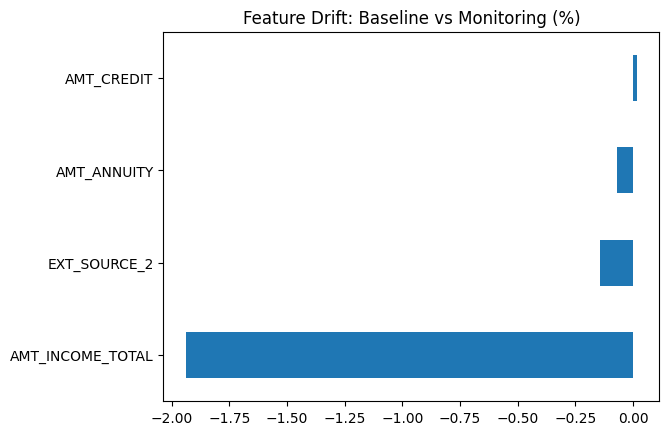

In [27]:
feature_shift_pct.sort_values().plot(
    kind='barh',
    title='Feature Drift: Baseline vs Monitoring (%)'
)


# insight 


### Income ↓ → affordability ↓ → approvals ↓

### Credit amount ↑ → risk ↑ → approvals ↓

### EXT_SOURCE_2 ↓ → creditworthiness ↓

# Root Cause Summary
# Approval rate drift was primarily driven by a decrease in applicant income and creditworthiness during the monitoring period. The average  income dropped significantly compared to baseline, increasing the proportion of high-risk applicants and leading to a higher rejection rate.